In [1]:
from Bio import PDB as pdb
%matplotlib inline
from matplotlib import pyplot as plt
# We'll be using itertools, which contains tools for creating iterators:
import itertools as it

# We'll again retrieve and load the closed clamp structure, 1czd, but also a structure of the open clamp on
# clamp loader, 3u60:
pdbl = pdb.PDBList()
filename_1czd = pdbl.retrieve_pdb_file('1czd')
filename_3u60 = pdbl.retrieve_pdb_file('3u60')
mmcifp = pdb.MMCIFParser()
structure_closed = mmcifp.get_structure('1czd', filename_1czd)
structure_open = mmcifp.get_structure('3u60', filename_3u60)

Structure exists: '/home/kent/kuriyanlab_python-workshops/2/cz/1czd.cif' 
Structure exists: '/home/kent/kuriyanlab_python-workshops/2/u6/3u60.cif' 


/opt/anaconda/envs/demo/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17571.
  PDBConstructionWarning,
/opt/anaconda/envs/demo/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17603.
  PDBConstructionWarning,
/opt/anaconda/envs/demo/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17635.
  PDBConstructionWarning,
/opt/anaconda/envs/demo/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 17667.
  PDBConstructionWarning,


Small-angle X-ray scattering (SAXS) intensity measures the Fourier transform of the pair distribution function between electrons in a protein or macromolecule of interest. We will play around with predicting this pair distribution function from static structures (an approximation) for two different clamp states: open as in clamp-loader-bound structures, and closed. We will make three approximations: disregarding hydrogens, which are not in these structures and contribute little to the scattering, localizing electrons at atomic coordinates, and counting electrons based on element only.

In [2]:
# First, let's make sure we can select just the clamp chains in the open structure, which also contains the clamp
# loader, DNA, and ligands. We happen to know that the 

In [3]:
maxdist_closed = 0
numpairs_closed = 0

for pair in it.combinations(structure_closed.get_atoms(), 2):
    if pair[0] - pair[1] > maxdist_closed:
        maxdist_closed = pair[0] - pair[1]
    numpairs_closed += 1
    
print(maxdist_closed)
print(numpairs_closed)

97.1033
13778625


In [4]:
maxdist_open = 0
numpairs_open = 0

open_atomiterator = it.chain(structure_open[0]['F'].get_atoms(),
                             structure_open[0]['G'].get_atoms(),
                             structure_open[0]['H'].get_atoms())

for pair in it.combinations(open_atomiterator, 2):
    if pair[0] - pair[1] > maxdist_open:
        maxdist_open = pair[0] - pair[1]
    numpairs_open += 1
    
print(maxdist_open)
print(numpairs_open)

103.357834
13778625


In [5]:
import numpy as np

atomicnumber = {'H': 1,
                 'C': 6,
                 'N': 7,
                 'O': 8,
                 'S': 16,
                 'SE': 16} # treat Se as S for this purpose

end = max([maxdist_closed, maxdist_open]) + 1e-6 # add a tiny bit to the end to ensure the max is less than it
nbins = 2000
binedges = np.linspace(0, end, nbins + 1)
pairdist_closed = np.zeros(nbins, dtype = int)
pairdist_open = np.zeros(nbins, dtype = int)

for pair in it.combinations(structure_closed.get_atoms(), 2):
    dist = pair[0] - pair[1]
    distbin = int(nbins * dist / end)
    pairdist_closed[distbin] += atomicnumber[pair[0].element] * atomicnumber[pair[1].element]

# We have to recreate the iterator from before, which has been exhausted
open_atomiterator = it.chain(structure_open[0]['F'].get_atoms(),
                             structure_open[0]['G'].get_atoms(),
                             structure_open[0]['H'].get_atoms())
    
for pair in it.combinations(open_atomiterator, 2):
    dist = pair[0] - pair[1]
    distbin = int(nbins * dist / end)
    pairdist_open[distbin] += atomicnumber[pair[0].element] * atomicnumber[pair[1].element]

Text(0.5, 1.0, 'Electronic pair distribution function for T4 clamp')

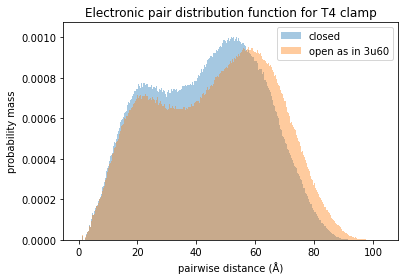

In [6]:
plt.bar(binedges[:-1], pairdist_closed / np.sum(pairdist_closed), binedges[1] - binedges[0],
        align = 'edge', alpha = 0.4)
plt.bar(binedges[:-1], pairdist_open / np.sum(pairdist_open), binedges[1] - binedges[0],
        align = 'edge', alpha = 0.4)
plt.legend(["closed", "open as in 3u60"])
plt.xlabel("pairwise distance (Å)")
plt.ylabel("probability mass")
plt.title("Electronic pair distribution function for T4 clamp")